In [264]:
import pandas as pd
import seaborn as sns
from datetime import datetime, date
import calendar
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from utils import oneHot, batch
import random
from __future__ import print_function
import tensorflow as tf
from tensorflow import reset_default_graph
import IPython.display as display
plt.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline  

## read data and preprocess

In [265]:
df = pd.read_csv('cleaned_sales+weather_data.csv')
df = df.drop('Unnamed: 0' , 1)

In [266]:
df['date'] = df['date'].map( lambda x: datetime.strptime( x, '%Y-%m-%d'))
df['weekofyear'] = df['date'].dt.weekofyear
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.weekday
df['dayofyear'] = df['date'].dt.dayofyear
df['station'] = df['station'].map( int )
df['year'] = df['date'].dt.year
# filter
df = df[df['oms'] > 0 ]
df[:10]

,EAN,Produkttekst,avance,chain_store,date,oms,postal_no,store_name,store_no,volume,station,temp,wind,sun,precipitations,weekofyear,month,weekday,dayofyear,year
0,5741000116975,Royal B X-mas 6x33ds,1,DagliBrugsen,2015-01-01,31.00,2300,COOP DAGLIBR BRYDES ALLE,1043,1,618800,5.5,6.1,0,1.9,1,1,3,1,2015
1,5741000131084,Royal Export 6x33 ds,-13,DagliBrugsen,2015-01-01,100.00,2300,COOP DAGLIBR BRYDES ALLE,1043,4,618800,5.5,6.1,0,1.9,1,1,3,1,2015
2,5741000140284,ROYAL PLATINUM 6-PAK,8,DagliBrugsen,2015-01-01,39.95,2300,COOP DAGLIBR BRYDES ALLE,1043,1,618800,5.5,6.1,0,1.9,1,1,3,1,2015
3,5741000131084,Royal Export 6x33 ds,17,DagliBrugsen,2015-01-01,79.90,2400,COOP DAGLIBR BISPEPARKEN,1053,2,618800,5.5,6.1,0,1.9,1,1,3,1,2015
4,5741000132463,Royal Exp. kuffert24,-19,DagliBrugsen,2015-01-01,299.85,2650,COOP LOKALBR FJELDSTEDVEJ,1082,3,618800,5.5,6.1,0,1.9,1,1,3,1,2015
5,5741000116494,Royal Class. 6x33 ds,10,DagliBrugsen,2015-01-01,40.95,2500,COOP LOKALBR HERMAN BANGS PLAD,1134,1,618800,5.5,6.1,0,1.9,1,1,3,1,2015
6,5741000117958,Royal Plsnr 6x33 ds,10,DagliBrugsen,2015-01-01,40.95,2500,COOP LOKALBR HERMAN BANGS PLAD,1134,1,618800,5.5,6.1,0,1.9,1,1,3,1,2015
7,5741000131077,Royal Export ds,7,DagliBrugsen,2015-01-01,24.00,2500,COOP LOKALBR HERMAN BANGS PLAD,1134,2,618800,5.5,6.1,0,1.9,1,1,3,1,2015
8,5741000132463,Royal Exp. kuffert24,-13,DagliBrugsen,2015-01-01,199.90,2610,COOP DAGLIBRUGSEN ISLEV TORV,1194,2,618800,5.5,6.1,0,1.9,1,1,3,1,2015
9,5741000135013,HEINEKEN KUFFERT,-13,DagliBrugsen,2015-01-01,199.90,2610,COOP DAGLIBRUGSEN ISLEV TORV,1194,2,618800,5.5,6.1,0,1.9,1,1,3,1,2015


## aggregate

In [267]:
features = ['oms','date','temp','sun','wind','precipitations', 'dayofyear','year','month','weekday', 'station']
q = df[features]
data = q#[ (q['month'] > 3) & (q['month'] < 10 ) ] #& (q['weekday'] == 4)]
# aggregate emp	wind	sun	precipitations
agg = data.groupby(['date', 'station' ])
aggregated_data = pd.DataFrame( { 'month' :  agg['month'].first() , 'weekday' :  agg['weekday'].first(), 'oms' : agg['oms'].sum(), 'temp':agg['temp'].first() , 'sun' : agg['sun'].first(), 'wind' : agg['wind'].first(),  'precipitations' : agg['precipitations'].first()  } )
aggregated_data.reset_index(level=0, inplace=True)
aggregated_data.reset_index(level=0, inplace=True)

aggregated_data[:3]

,station,date,month,oms,precipitations,sun,temp,weekday,wind
0,603100,2015-01-01,1,22080.76,4.5,0,6.7,3,8.7
1,607200,2015-01-01,1,36691.96,1.0,0,6.8,3,5.7
2,612600,2015-01-01,1,28939.93,0.3,0,5.4,3,8.6


## normalize

In [182]:
from sklearn import preprocessing
def normalize(X):
    mean = np.mean(X)
    std = np.std(X)
    return (X - mean)/std
aggregated_data['precipitations'] = normalize(aggregated_data['precipitations'])
aggregated_data['oms'] = normalize(aggregated_data['oms'])
aggregated_data['wind'] = normalize(aggregated_data['wind'])
aggregated_data['sun'] = normalize(aggregated_data['sun'])
aggregated_data['temp'] = normalize(aggregated_data['temp'])
aggregated_data[:3]
aggregated_data.describe()

,station,month,oms,precipitations,sun,temp,weekday,wind
count,3310.000000,3310.000000,3.310000e+03,3.310000e+03,3.310000e+03,3.310000e+03,3310.000000,3.310000e+03
mean,611820.000000,6.018127,-7.110794e-17,2.297591e-17,5.138555e-17,-5.896592e-16,3.009063,-2.292896e-16
std,5964.926601,3.229366,1.000151e+00,1.000151e+00,1.000151e+00,1.000151e+00,1.999526,1.000151e+00
min,603100.000000,1.000000,-1.966860e+00,-5.079364e-01,-1.132734e+00,-3.162310e+00,0.000000,-1.801694e+00
25%,607200.000000,3.000000,-7.230571e-01,-5.079364e-01,-9.247844e-01,-8.001145e-01,1.000000,-7.390127e-01
50%,612600.000000,6.000000,-1.762144e-01,-4.829108e-01,-1.854092e-01,-1.271602e-02,3.000000,-1.545382e-01
75%,617400.000000,9.000000,5.693828e-01,6.765227e-02,6.925988e-01,8.462641e-01,5.000000,5.362044e-01
max,618800.000000,12.000000,5.400386e+00,8.976764e+00,2.587248e+00,2.395797e+00,6.000000,4.840062e+00


## setup train and tests data

In [268]:
features = ['month','precipitations','sun','temp','wind','weekday','station']
data = aggregated_data[features]
data = oneHot(data, 'weekday')
data = oneHot(data, 'station')
data = oneHot(data, 'month')
features = data.columns.values
labels = ['oms']
X = data.as_matrix()
y = aggregated_data[labels].values
data[:3]

,precipitations,sun,temp,wind,weekday=0,weekday=1,weekday=2,weekday=3,weekday=4,weekday=5,...,month=12,month=8,month=9,month=6,month=7,month=4,month=5,month=2,month=3,month=1
0,4.5,0,6.7,8.7,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,0,6.8,5.7,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0.3,0,5.4,8.6,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [269]:
full_training = False
train_ratio = 0.9
L = len(y)
idx = range(L)
random.shuffle(idx)
if not full_training:
    X_train = X[ idx[ : int(0.8 * L)  ]  , : ]
    y_train = y[ idx[ : int(0.8 * L)  ] , : ]
else:
    X_train = X
    y_train = y
X_test = X[ idx[ int(0.8 * L)  : ]  , : ]
y_test = y[ idx[ int(0.8 * L)  : ] , :]

## define accuracy function

In [270]:
def getAcc(pred,true):
    return 1 - abs( 1 - pred/true )

# Random Forest Regressor

accuracy: 0.859682745


/Users/valentin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


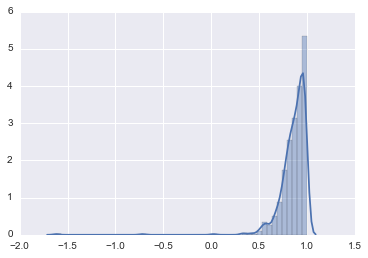

In [272]:
rfr = RandomForestRegressor(n_estimators=200, min_samples_split=5)
rfr.fit(X_train, y_train)
pred = rfr.predict(X_test)
scores = []
raw_scores = []
for i in range(len(pred)):
    e = getAcc(pred[i],y_test[i])
    scores.append(e)
    raw_scores.append(pred[i] / y_test[i])
print("accuracy: " + str(np.mean(scores)) )
sns.distplot(scores)

## build a logistic regressor using tensorflow

In [158]:
# inspire: http://stackoverflow.com/questions/34208336/tensorflow-multivariate-linear-regression-not-converging
# http://stackoverflow.com/questions/36637901/building-a-non-linear-model-with-relus-in-tensorflow



In [399]:
tf.reset_default_graph()

logs_path = '/tmp/tensorflow_logs/OiX-regressor'
epoches = 60
batch_len = 16
hidden_units = 6
learning_rate =  1e-1

batch_gen = batch(X_train,y_train,batch_len)

n_input = X_train.shape[1]
n_output = y_train.shape[1]

def weight_variable(shape , name='xxx'):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name = name)

def bias_variable(shape, name='xxx'):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name = name)

# create placeholders to pass the data to the model
x = tf.placeholder('float', shape=[None, n_input], name='InputData')
y_ = tf.placeholder('float', shape=[None, n_output], name='LabelData')

W1 = weight_variable([n_input, hidden_units], name='W1')
b1 = bias_variable([hidden_units], name='b1')
r1 = tf.nn.relu(tf.matmul(x, W1) + b1)

# Input of r1 into r2 (which is just y)
W2 = weight_variable([hidden_units, n_output], name='W2')
b2 = bias_variable([n_output], name='b2')
yt =  tf.matmul(r1,W2)+b2 
ytt = tf.nn.relu(yt) 

with tf.name_scope('Model'):
    y = ytt
    
# OPTION 2 
# Add r1 to r2 -- won't be able to reduce the error.
#W2 = weight_variable([n_input, hidden_units])
#b2 = bias_variable([hidden_units])
#r2 = tf.nn.relu(tf.matmul(x, W2) + b2)
#y = tf.add(r1,r2)

with tf.name_scope('MSE'):
    mean_square_error = tf.reduce_sum(tf.square(tf.sub(y,y_)))

with tf.name_scope('Optimizer'):
    training = tf.train.AdamOptimizer(learning_rate).minimize(mean_square_error)

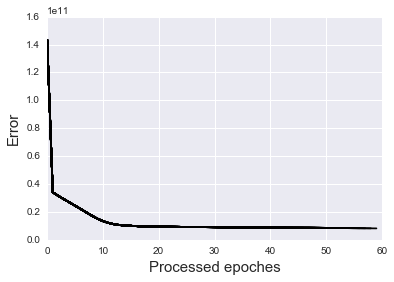

In [400]:
sess = tf.InteractiveSession()

# Create a summary to monitor cost tensor
tf.scalar_summary("MSE", mean_square_error)

# merge all summaries
merged_summary_op = tf.merge_all_summaries()

sess.run(tf.initialize_all_variables())
summary_writer = tf.train.SummaryWriter(logs_path, graph=tf.get_default_graph())


XX = []
YY = []
min_error = np.inf
for k in range(epoches):
    # iterrate trough every row (with batch size of 1)
    for i in range(X_train.shape[0]/batch_len):
        Xs,ys = batch_gen.getNextBatch()
        _, error, summary = sess.run([training, mean_square_error, merged_summary_op],  feed_dict={x: Xs, y_:ys})
        summary_writer.add_summary(summary, k * batch_len + i)
    
    YY.append(error)
    XX.append(k)
    plt.plot(XX, YY, 'black')
    plt.ylabel('Error', fontsize=15)
    plt.xlabel('Processed epoches', fontsize=15)
    plt.title('', fontsize=20)
    plt.grid('on')
    plt.savefig("out.png")
    display.display(display.Image(filename="out.png"))
    display.clear_output(wait=True)

MSE: 4.53175e+11
accuracy: 0.980962469212
mean real values: 135922.347145
mean diff: 18027.9912779
mean diff error: 13.2634490623%


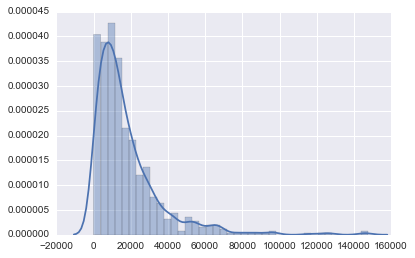

In [401]:
print("MSE: " + str( sess.run(mean_square_error,  feed_dict={x: X_test, y_:y_test}) ) )
reg_pred = sess.run(y, feed_dict={x:X_test})
scores = []
diffs = []
for i in range(len(reg_pred)):
    scores.append(ee)
    diffs.append(abs(reg_pred[i]-y_test[i]))
print("accuracy: " + str(np.mean(scores)))
print("mean real values: " + str(np.mean(y_test)))
print("mean diff: " + str(np.mean(diffs)))
print("mean diff error: " + str(np.mean(diffs) / np.mean(y_test) * 100) + "%")
sns.distplot(diffs)

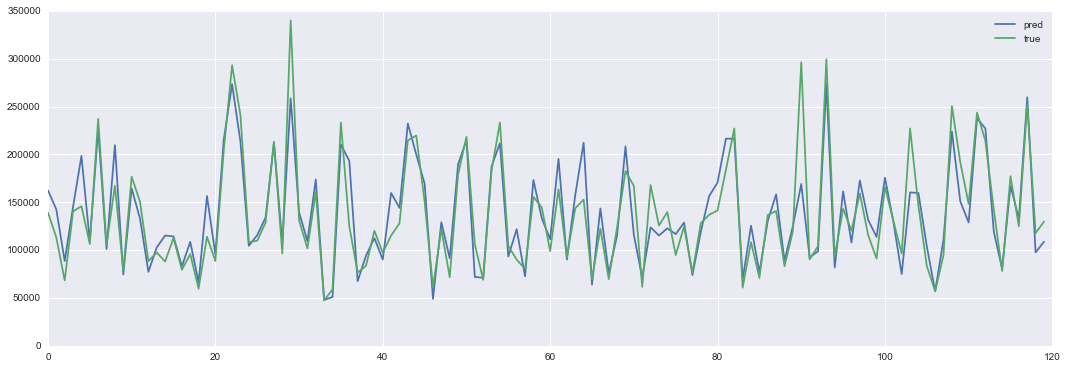

In [402]:
plt.figure(figsize=(18,6))
N = 120
plt.plot(reg_pred[:N],label='pred')
plt.plot(y_test[:N],label='true')
plt.legend()
plt.show()